In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers,models
import tensorflow as tf
import os
import math


In [4]:
image_size=256

In [10]:
dataset=tf.keras.preprocessing.image_dataset_from_directory('tomato_image',batch_size=32,image_size=(image_size,image_size),shuffle=True)


Found 16006 files belonging to 10 classes.


In [45]:
len(dataset.class_names)

10

In [12]:
clases_names=dataset.class_names
clases_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [14]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
(32,)
[7 7 8 5 6 7 2 1 6 0 9 7 8 1 1 9 7 7 6 9 7 7 3 2 2 3 5 4 5 6 2 6]


C:\Users\aswin\AppData\Local\Temp\ipykernel_4536\1006319162.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


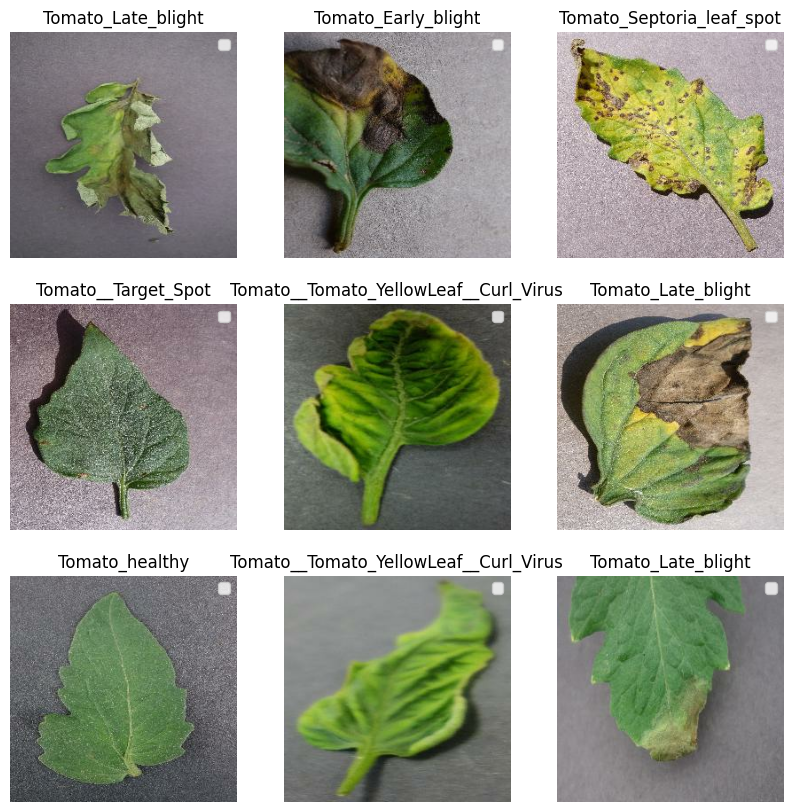

In [19]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(clases_names[label_batch[i]])
        plt.legend()
        plt.axis('off')

In [20]:
len(dataset)

501

In [21]:
train_size=0.8
train_size*len(dataset)

400.8

In [22]:
test_size=0.1
test_size*len(dataset)

50.1

In [23]:
val_size=0.1
val_size*len(dataset)

50.1

In [24]:
train_ds=dataset.take(400)
len(train_ds)

400

In [27]:
test_ds=dataset.skip(400)
len(test_ds)

101

In [28]:
val_ds=test_ds.skip(51)
len(val_ds)

50

In [35]:
def dataset_partition(ds,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):
    ds=len(dataset)
    if shuffle:
        ds=dataset.shuffle(shuffle_size,seed=10)
        train_size=int(len(dataset)*0.8)
        val_size=int(len(dataset)*0.1)
        test_size=int(len(dataset)*0.1)
        train_ds=dataset.take(train_size)
        val_ds=dataset.skip(train_size)
        test_ds=dataset.skip(train_size).skip(val_size)
        return train_ds,test_ds,val_ds
        

In [36]:
train_ds,test_ds,val_ds=dataset_partition(dataset)

In [37]:
len(train_ds)

400

In [38]:
len(test_ds)

51

In [39]:
len(val_ds)

101

In [40]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [42]:
resize_and_rescale=keras.Sequential([
    layers.Resizing(image_size,image_size),
    layers.Rescaling(1./256)])

In [44]:
data_agumentation=keras.Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical'),
    layers.RandomRotation(0.3)])

In [49]:
n_clases=10
batch_size=32
channels=3
input_shape=(image_size,image_size,channels)
model=models.Sequential([
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(1000,activation='relu'),
    layers.Dense(n_clases,activation='softmax')])

In [50]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1000)                │      12,545,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │          10,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,648,258 (48.25 MB)

 Trainable params: 12,648,258 (48.25 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
model.compile(optimizer='adam',loss='SparseCategoricalCrossentropy',metrics=['accuracy'])

In [59]:
final=model.fit(train_ds,epochs=6,validation_data=val_ds,batch_size=batch_size,verbose=1)
final

Epoch 1/6
400/400 ━━━━━━━━━━━━━━━━━━━━ 448s 1s/step - accuracy: 0.4366 - loss: 1.6628 - val_accuracy: 0.5680 - val_loss: 1.2899
Epoch 2/6
400/400 ━━━━━━━━━━━━━━━━━━━━ 368s 920ms/step - accuracy: 0.7248 - loss: 0.8103 - val_accuracy: 0.7885 - val_loss: 0.6283
Epoch 3/6
400/400 ━━━━━━━━━━━━━━━━━━━━ 368s 920ms/step - accuracy: 0.8291 - loss: 0.5025 - val_accuracy: 0.8263 - val_loss: 0.5322
Epoch 4/6
400/400 ━━━━━━━━━━━━━━━━━━━━ 330s 826ms/step - accuracy: 0.9036 - loss: 0.2767 - val_accuracy: 0.8472 - val_loss: 0.4982
Epoch 5/6
400/400 ━━━━━━━━━━━━━━━━━━━━ 321s 804ms/step - accuracy: 0.9388 - loss: 0.1818 - val_accuracy: 0.8490 - val_loss: 0.5924
Epoch 6/6
400/400 ━━━━━━━━━━━━━━━━━━━━ 317s 791ms/step - accuracy: 0.9595 - loss: 0.1217 - val_accuracy: 0.8525 - val_loss: 0.5897


In [61]:
score=model.evaluate(test_ds)
score

51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 197ms/step - accuracy: 0.8474 - loss: 0.5744


[0.5744390487670898, 0.8474470973014832]

In [62]:
final.params

{'verbose': 1, 'epochs': 6, 'steps': 400}

In [66]:
final.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [67]:
final.history['accuracy'][:5]

[0.4366406202316284,
 0.7247655987739563,
 0.8291406035423279,
 0.9035937786102295,
 0.9387500286102295]

In [68]:
len(final.history['accuracy'])

6

In [70]:
acc=final.history['accuracy']
loss=final.history['loss']
val_accuracy=final.history['val_accuracy']
val_loss=final.history['val_loss']


In [71]:
len(acc)

6

In [72]:
epochs=range(len(acc))

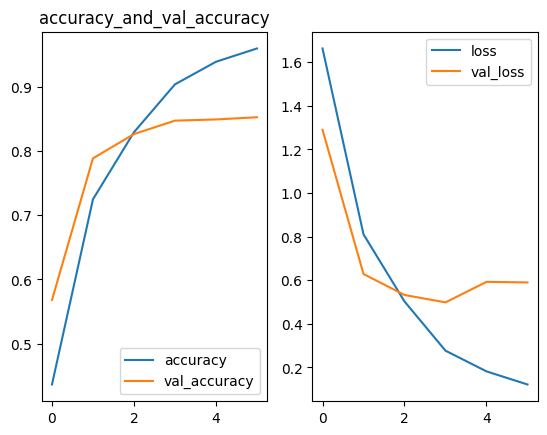

In [75]:
plt.subplot(1,2,1)
plt.plot(epochs,acc,label='accuracy')
plt.plot(epochs,val_accuracy,label='val_accuracy')
plt.title('accuracy_and_val_accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs,loss,label='loss')
plt.plot(epochs,val_loss,label='val_loss')
plt.legend()


actual_label:,Tomato_Spider_mites_Two_spotted_spider_mite
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
predicted_label:,Tomato_Spider_mites_Two_spotted_spider_mite


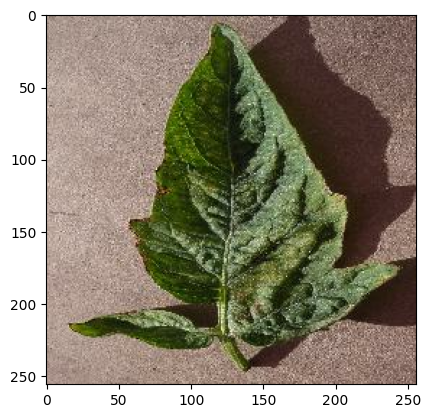

In [88]:
for image_batch,label_batch in dataset.take(1):
    first_image=plt.imshow(image_batch[0].numpy().astype('uint8'))
    first_label=clases_names[label_batch[0]]
    print(f'actual_label:,{first_label}')

    predicted=model.predict(image_batch)
    predicted_label=clases_names[np.argmax(predicted[0])]
    print(f'predicted_label:,{predicted_label}')

In [122]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(img)
    img_exapnd=tf.expand_dims(img_array,0)
    prediction=model.predict(img_exapnd)
    predicted_label=clases_names[np.argmax(prediction[0])]
    confidence=round(100*(np.max(prediction[0])),2)
    return predicted_label,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


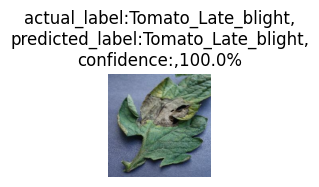

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


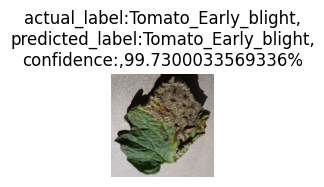

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


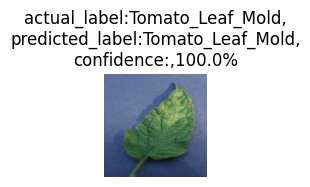

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


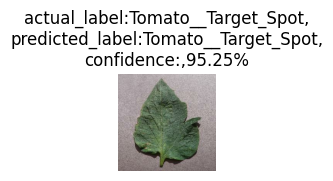

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


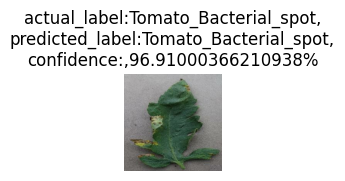

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


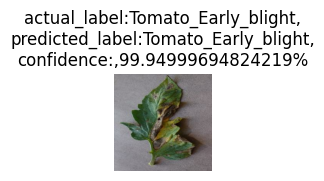

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


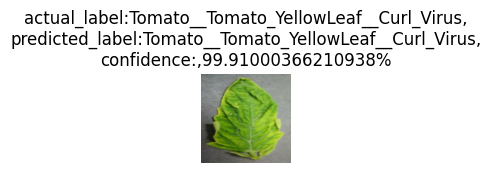

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


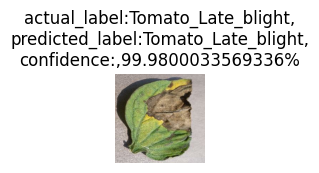

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


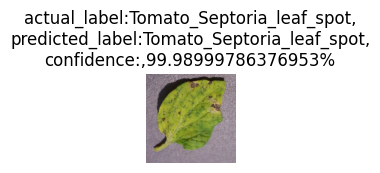

In [152]:
plt.Figure(figsize=(30,30))
for image,label in dataset.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        predicted_label,confidence=predict(model,image[i])
        actual_label=clases_names[label[i]]
        plt.title(f'actual_label:{actual_label},\npredicted_label:{predicted_label},\nconfidence:,{confidence}%')
        plt.tight_layout()
        plt.axis('off')
        plt.show()
        
        

        
        

In [153]:
model_version=2
model.export(f"C:/Users/aswin/projects/deeplearning_project2/tomato/model/{model_version}")

INFO:tensorflow:Assets written to: C:/Users/aswin/projects/deeplearning_project2/tomato/model/2\assets


INFO:tensorflow:Assets written to: C:/Users/aswin/projects/deeplearning_project2/tomato/model/2\assets


Saved artifact at 'C:/Users/aswin/projects/deeplearning_project2/tomato/model/2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_1')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  2751537904336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2751537905104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2751537904720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2751537905488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2751537905296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2751537904912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2751537903376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2751537902224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2751538758480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2751538758864: TensorSpec(shape=(), dtype=tf.resource, 